In [2]:
import pandas as pd
import numpy as np

In [9]:
import os 
os.chdir("/Users/eddy/Downloads")

In [10]:
data = pd.read_csv('imports-85.data', header=None, na_values='?')
data.columns = ['symboling', 
    'normalized-losses', 
    'make', 
    'fuel-type', 
    'aspiration', 
    'num-of-doors', 
    'body-style', 
    'drive-wheels', 
    'engine-location', 
    'wheel-base', 
    'length', 
    'width', 
    'height', 
    'curb-weight', 
    'engine-type', 
    'num-of-cylinders', 
    'engine-size', 
    'fuel-system', 
    'bore', 
    'stroke', 
    'compression-ratio', 
    'horsepower',
    'peak-rpm',
    'city-mpg',
    'highway-mpg',
    'price']
data.head().T

,0,1,2,3,4
symboling,3,3,1,2,2
normalized-losses,NaN,NaN,NaN,164,164
make,alfa-romero,alfa-romero,alfa-romero,audi,audi
fuel-type,gas,gas,gas,gas,gas
aspiration,std,std,std,std,std
num-of-doors,two,two,two,four,four
body-style,convertible,convertible,hatchback,sedan,sedan
drive-wheels,rwd,rwd,rwd,fwd,4wd
engine-location,front,front,front,front,front
wheel-base,88.6,88.6,94.5,99.8,99.4


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
data.shape

(205, 26)

In [14]:

data.price.isnull().sum()

4

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


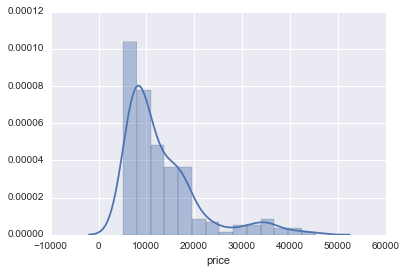

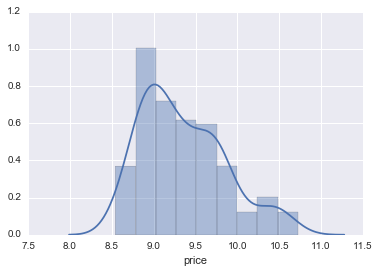

In [16]:
data = data[~data.price.isnull()]

sns.distplot(data.price)
plt.show()
sns.distplot(np.log(data.price))
plt.show()


It makes more sense to predict the log of price instead of price. In this case the evaluation metric RMSE becomes RMSLE, which tells us the order of mistake, not its absolute value - which is good for prices, especially big ones.
Now let's create a model. First, we hold out some data to be used for testing

In [17]:
from sklearn.cross_validation import train_test_split
df_train, df_test = train_test_split(data, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=1)
df_test =  df_test.reset_index(drop=1)

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:

numerical = [
    'symboling',
    'normalized-losses',
    'wheel-base',
    'length',
    'width',
    'height',
    'curb-weight',
    'engine-size',
    'bore',
    'stroke',
    'compression-ratio',
    'horsepower',
    'peak-rpm',
    'city-mpg',
    'highway-mpg',
]

In [19]:
nulls_columns = df_train[numerical].isnull().sum()
nulls_columns = list(nulls_columns[nulls_columns > 0].index)
nulls_columns

['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm']

In [20]:
for col_name in nulls_columns:
    median = df_train[col_name].median()

    nulls = df_train[col_name].isnull()
    df_train.loc[nulls, col_name] = median
    
    nulls = df_test[col_name].isnull()
    df_test.loc[nulls, col_name] = median

In [21]:

from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()

num_train = scaler.fit_transform(df_train[numerical].values)
num_test =  scaler.transform(df_test[numerical].values)

In [23]:

from sklearn.feature_extraction.text import CountVectorizer

In [24]:

categorical = [
    'make',
    'fuel-type',
    'aspiration',
    'num-of-doors',
    'body-style',
    'drive-wheels',
    'engine-location',
    'engine-type',
    'num-of-cylinders',
]

In [25]:
def join_dict(d):
    return ' '.join('%s=%s' % (k, v.replace(' ', '_')) for (k, v) in d.items() if v)

dicts_train = df_train[categorical].fillna('').to_dict(orient='records')
dicts_train = [join_dict(d) for d in dicts_train]

dicts_test = df_test[categorical].fillna('').to_dict(orient='records')
dicts_test = [join_dict(d) for d in dicts_test]

In [26]:
cv = CountVectorizer(analyzer=str.split, min_df=5, dtype='uint8')
cat_train = cv.fit_transform(dicts_train)
cat_test = cv.transform(dicts_test)

In [27]:
y_train = np.log(df_train.price.values)
y_test = np.log(df_test.price.values)

X_train = np.hstack([num_train, cat_train.toarray()])
X_test = np.hstack([num_test, cat_test.toarray()])

In [28]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

In [30]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [31]:
ols = LinearRegression()
ols.fit(X_train, y_train)

y_pred = ols.predict(X_test)
rmse(y_test, y_pred)

0.15029016446987475

In [32]:
lasso = Lasso(alpha=0.001, random_state=1)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)
rmse(y_test, y_pred)

0.13867348321109671

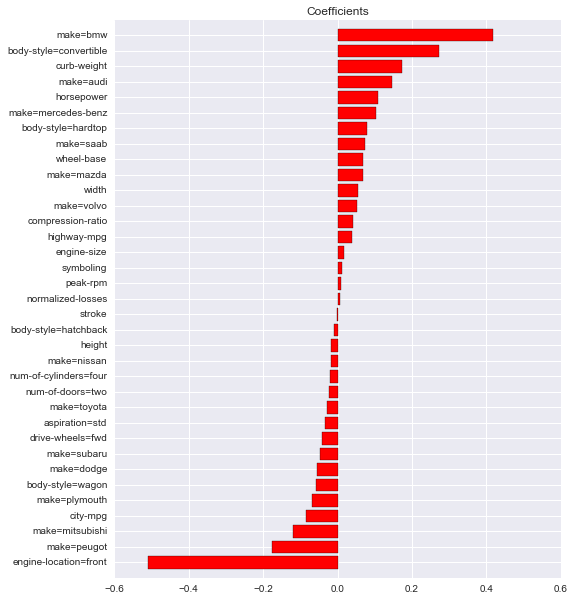

In [33]:
features = np.array(numerical + cv.get_feature_names())
coef = lasso.coef_
features = features[coef != 0.0]
coef = coef[coef != 0]
coef_idx = np.argsort(coef)

plt.figure(figsize=(8, 10))
plt.title("Coefficients")
coef_num = range(len(coef))
plt.barh(coef_num, coef[coef_idx], color="r", align="center")

plt.yticks(coef_num, features[coef_idx])
plt.ylim([-1, len(features)])

plt.show()